# Flower Classifier with CNN

In this notebook I create a model that will take an image of flower and  classify it into 102 different kinds of species. 
The model will use a convolutional neural network (CNN), a very powerfull deep learning framework which
has been applied in many fields such as in recommender systems,  image and video recognition, medical image analysis, natural language processing, and many more. Moreover,
I will use PyTorch to implement the neural network and build the model.

The main reason why I choose Pytorch is because in compare to TensorFlow, Keras, or Keano, I  find that Pytorch is a lot more
easier to use.
Some models are very difficult to create with TensorFlow or Keras but can be created easily with PyTorch. I don't know why but I find that 
they make simple things a lot harder than they should be.
In PyTorch, since it is specifically created for Python, I can use standard python control flow and use python debuggers. 
Moreover PyTorch is very similar to NumPy in terms of computation. So since I am already familiar with numpy, it is not hard to switch working with PyTorch.


In [0]:
import torch


Ok now back to the flower classification problem. I will consider the 
102-Oxford flower dataset which is available [here](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/). 
It has 8189 images which is divided into 102 categories with 40 to 250 images per category.

Note that any RGB image can be seen as a three dimensional array. 
For example, an image with 100x100 pixels is represented as  a  100x100x3 array. The first two dimension represent the width and height of the image and the last one represents the color channels: red, green, and blue. 
So each pixel in the image has a numerical value that represent the intensity of red, green, and blue. For example,
white pixels are encoded as the value 255,255,255,  red pixels are encoded as 255,0,0, pink pixels 
  fall somewhere in between, e.g. 255,192,203,
with light-pink being closer to 255,255,255.

## Loading, Augmenting and Preprocessing the Data

I have splitted the dataset into  training, validation, and testing datasets and I load them 
by using 'torchvision' . In the following I define the dataloaders for these three datasets.




Beside loading the dataset, I will also augment the training data. Into the training dataset I will add some images that are rotated, flipped, or cropped.
In this way hopefully I will obtain a robust model that can also predict correctly even if it sees a rotated, flipped, or cropped image.

I also make sure that the image data is resized to 224x224 pixels because this is the dimension of image that is 
considered by many image classifier that utilises CNN. It is also the dimension that suits  a pretrained-neural-nework that I will consider later.

Moreover the pre-trained networks that I will use  were trained on the  dataset where each color channel was normalized separately. So for both training and validation sets I need to normalize the means and standard deviations of the images to what the network expects. The mean is `[0.485, 0.456, 0.406]` and  the standard deviations is `[0.229, 0.224, 0.225]`.

In [0]:
data_dir = '/content/drive/My Drive/Colab Notebooks/flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
from torchvision import datasets, transforms

# use transforms to augment the training and validation sets
train_transforms = transforms.Compose([transforms.RandomRotation(45),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
 

# load datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=valid_transforms)

# use the image datasets and the trainforms and define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(valid_data, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20, num_workers=0)

# get the classes
classes = train_data.classes



### Viewing the Data and Mapping the Label

Before I define the model let us look at the dataset. The dataset comes with a mapping that maps the label, i.e. the folder name, to the actual flower name. It is available in the file:
`cat_to_name.json`. I then show the first 20 image from our training data. 
 

In [0]:
import json
# load the map from label number (1 - 102) to the actual flower name
with open('/content/drive/My Drive/Colab Notebooks/cat_to_name.json', 'r') as f:
    label_map = json.load(f) 

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# function to un-normalize and display an image
def imageshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

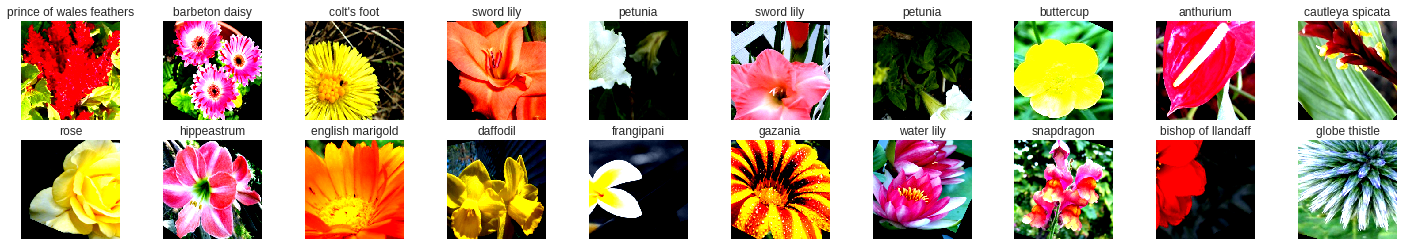

In [6]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  imageshow(images[idx])
  ax.set_title(label_map[classes[labels[idx]]])

## Building Model

The data is now preprocessed  and I will build the model that will be trained by using the training dataset. I  will use a pretrained models,  ResNet152, that is available in  `torchvision.models` to recognize the features of the image, like the shape, color, etc.  I then will build   a new feed-forward classifier that will use those features. 
In the following, I print out the model architecture so we can see what is going on. 
 

 

In [7]:
from torchvision import models
model = models.resnet152(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:09<00:00, 25482050.74it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

 

## Defining a New  Feedforward Classifier

So ResNet152 basically is built out of ten main parts. 
Most of them are stacks of convolutional layers and overall works as a feature detector that can be fed into a classifier in the last part.
The classifier is a single fully-connected layer and was trained on the ImageNet dataset, so it will not work for the flower classification problem.  I need to replace this layer. In the following, I define a new, untrained feed-forward network as a classifier. I consider fully-connected layers with two layers with a ReLU activation.
 

In [8]:
for param in model.parameters():
    param.requires_grad = False

from torch import nn    
from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 1000)),
                          ('relu', nn.ReLU()), 
                          ('fc2', nn.Linear(1000, 102)), 
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.fc = classifier
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

# Training the Model

I have build the  model and now I need to train the classifier. Note that now I have a very deep neural network. If I train this on a normal CPU, it will take a very long time. So I am going to use the GPU to do the training. With GPU computation, the linear algebra calculations are done in parallel. The time we need for training can be 100x faster.  

With PyTorch, we can use [CUDA](https://developer.nvidia.com/cuda-zone) and  compute the forward and backwards passes on the GPU efficiently. I move the model parameters and other tensors to the GPU memory by using `model.to('cuda')`. I can then move them back from the GPU with `model.to('cpu')`.

In [9]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### Defining [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Here I define the loss and optimization function that is best suited for this flower classification task. 
I set it to be the negative  log of  likelihood loss and set the learning rate to be 0.0015. The learning rate will determine how the model converges to a small error. Moreover I will only train the parameter of the last part of the model.

In [0]:
from torch import optim
criterion = nn.NLLLoss()

# train the classifier parameters only, not feature parameters  
optimizer = optim.Adam(model.fc.parameters(), lr=0.0002)


I train the classifier layers by using backpropagation and the classifier layer will use the pre-trained network to get the features.  

I also track the loss and accuracy on the validation set.

In [11]:
import utils
gsync = utils.GDriveSync() # define gsync to save the model in my google drive

In [12]:
import torch.nn.functional as F


model.cuda() # move the model to GPU
n_epochs = 45 #  number of epochs in training

valid_loss_min = np.Inf # track changes in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(testloader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        gsync.update_file_to_folder("model.pt")
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 3.633438 	Validation Loss: 2.384641
Validation loss decreased (inf --> 2.384641).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 13.22it/s]            


Epoch: 2 	Training Loss: 1.974994 	Validation Loss: 1.220390
Validation loss decreased (2.384641 --> 1.220390).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 12.73it/s]            


Epoch: 3 	Training Loss: 1.236294 	Validation Loss: 0.733426
Validation loss decreased (1.220390 --> 0.733426).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 13.32it/s]            


Epoch: 4 	Training Loss: 0.901856 	Validation Loss: 0.545489
Validation loss decreased (0.733426 --> 0.545489).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 12.78it/s]            


Epoch: 5 	Training Loss: 0.732479 	Validation Loss: 0.439537
Validation loss decreased (0.545489 --> 0.439537).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 12.65it/s]            


Epoch: 6 	Training Loss: 0.660961 	Validation Loss: 0.377162
Validation loss decreased (0.439537 --> 0.377162).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 11.94it/s]            


Epoch: 7 	Training Loss: 0.566907 	Validation Loss: 0.338376
Validation loss decreased (0.377162 --> 0.338376).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:07<00:00, 12.10it/s]            


Epoch: 8 	Training Loss: 0.548750 	Validation Loss: 0.310952
Validation loss decreased (0.338376 --> 0.310952).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:07<00:00, 12.51it/s]            


Epoch: 9 	Training Loss: 0.488244 	Validation Loss: 0.289304
Validation loss decreased (0.310952 --> 0.289304).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:05<00:00, 13.83it/s]            


Epoch: 10 	Training Loss: 0.461445 	Validation Loss: 0.277098
Validation loss decreased (0.289304 --> 0.277098).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 13.17it/s]            


Epoch: 11 	Training Loss: 0.430756 	Validation Loss: 0.276176
Validation loss decreased (0.277098 --> 0.276176).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 13.89it/s]            


Epoch: 12 	Training Loss: 0.413510 	Validation Loss: 0.239437
Validation loss decreased (0.276176 --> 0.239437).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:05<00:00, 16.18it/s]            


Epoch: 13 	Training Loss: 0.385008 	Validation Loss: 0.254620
Epoch: 14 	Training Loss: 0.390989 	Validation Loss: 0.232045
Validation loss decreased (0.239437 --> 0.232045).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:05<00:00, 14.55it/s]            


Epoch: 15 	Training Loss: 0.377980 	Validation Loss: 0.220312
Validation loss decreased (0.232045 --> 0.220312).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 13.63it/s]            


Epoch: 16 	Training Loss: 0.353502 	Validation Loss: 0.232121
Epoch: 17 	Training Loss: 0.347191 	Validation Loss: 0.243673
Epoch: 18 	Training Loss: 0.337177 	Validation Loss: 0.238611
Epoch: 19 	Training Loss: 0.322772 	Validation Loss: 0.215790
Validation loss decreased (0.220312 --> 0.215790).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:05<00:00, 15.53it/s]            


Epoch: 20 	Training Loss: 0.344068 	Validation Loss: 0.202426
Validation loss decreased (0.215790 --> 0.202426).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:05<00:00, 14.42it/s]            


Epoch: 21 	Training Loss: 0.314737 	Validation Loss: 0.231484
Epoch: 22 	Training Loss: 0.308663 	Validation Loss: 0.185548
Validation loss decreased (0.202426 --> 0.185548).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:05<00:00, 13.55it/s]            


Epoch: 23 	Training Loss: 0.300667 	Validation Loss: 0.203202
Epoch: 24 	Training Loss: 0.306607 	Validation Loss: 0.204454
Epoch: 25 	Training Loss: 0.273176 	Validation Loss: 0.191022
Epoch: 26 	Training Loss: 0.289727 	Validation Loss: 0.190314
Epoch: 27 	Training Loss: 0.282198 	Validation Loss: 0.207617
Epoch: 28 	Training Loss: 0.279471 	Validation Loss: 0.191654
Epoch: 29 	Training Loss: 0.263134 	Validation Loss: 0.197608
Epoch: 30 	Training Loss: 0.279600 	Validation Loss: 0.199773
Epoch: 31 	Training Loss: 0.275733 	Validation Loss: 0.176309
Validation loss decreased (0.185548 --> 0.176309).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 12.01it/s]            


Epoch: 32 	Training Loss: 0.269492 	Validation Loss: 0.189710
Epoch: 33 	Training Loss: 0.254235 	Validation Loss: 0.174254
Validation loss decreased (0.176309 --> 0.174254).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 12.82it/s]            


Epoch: 34 	Training Loss: 0.244467 	Validation Loss: 0.174140
Validation loss decreased (0.174254 --> 0.174140).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 12.79it/s]            


Epoch: 35 	Training Loss: 0.237598 	Validation Loss: 0.196363
Epoch: 36 	Training Loss: 0.269097 	Validation Loss: 0.177879
Epoch: 37 	Training Loss: 0.237404 	Validation Loss: 0.178544
Epoch: 38 	Training Loss: 0.251923 	Validation Loss: 0.172618
Validation loss decreased (0.174140 --> 0.172618).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:06<00:00, 13.39it/s]            


Epoch: 39 	Training Loss: 0.233522 	Validation Loss: 0.174966
Epoch: 40 	Training Loss: 0.242986 	Validation Loss: 0.186693
Epoch: 41 	Training Loss: 0.245072 	Validation Loss: 0.171747
Validation loss decreased (0.172618 --> 0.171747).  Saving model ...


Uploading file model.pt: 100%|██████████| 100.0/100 [00:05<00:00, 15.13it/s]            


Epoch: 42 	Training Loss: 0.233841 	Validation Loss: 0.187580
Epoch: 43 	Training Loss: 0.220522 	Validation Loss: 0.180084
Epoch: 44 	Training Loss: 0.239370 	Validation Loss: 0.183460
Epoch: 45 	Training Loss: 0.223329 	Validation Loss: 0.176241


Note that the parameters of the feedforward classifier now are already appropriately trained. The parameters of the feature network are left static.

## Checkpoint Saving

Now the model is trained. I save the model so I can load it later for making predictions. I also want to save other things like the mapping of classes to indices which I can get from one of the image datasets: `image_datasets['train'].class_to_idx`. I attach this to the model as an attribute so I could makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

I want to completely rebuild the model later so I  can use it for inference. I make sure to include any information I need in the checkpoint. If I want to load the model and keep training, I have to save the number of epochs as well as the optimizer state, `optimizer.state_dict`.  I will use this trained model in the next part of my project. It would be nice if I can have a mobile app where I can take a picture of a flower and it tells me what the species is and then looks up information about it. So it is best to save it.

In [13]:
model.class_to_idx = train_data.class_to_idx
checkpoint = {'arch': 'resnet152',
              'epoch': n_epochs, 
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict(),
              'valid_loss_min': valid_loss_min,
              'class_to_idx': model.class_to_idx}

torch.save(checkpoint, 'checkpoint.pth')
gsync.update_file_to_folder("checkpoint.pth")

Uploading file checkpoint.pth: 100%|██████████| 100.0/100 [00:06<00:00, 14.35it/s]            


## Loading the checkpoint

Here I write a function that   loads a checkpoint and rebuild the model. That way I can come back to this project and keep working on it without having to retrain the network.

In [0]:
def load_model(path):
    checkpoint = torch.load(path)
    
    if checkpoint['arch'] == 'resnet152':
        model = models.resnet152(pretrained=True)
        for param in model.parameters():
            param.requires_grad = False

    else:
        print("Sorry, the architecture is not recognised") 
        return
    
    model.class_to_idx = checkpoint['class_to_idx']
    
    # create the classifier
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(2048, 1000)),
        ('relu', nn.ReLU()), 
        ('fc2', nn.Linear(1000, 102)), 
        ('output', nn.LogSoftmax(dim=1))
    ]))
      

    # put the classifier on the pretrained network
    model.fc = classifier
    model.cuda() 
    
    optimizer = optim.Adam(model.fc.parameters(), lr=0.0002)
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    valid_loss_min = (checkpoint['valid_loss_min'])
    epoch = checkpoint['epoch'] + 1
    
    print("=> loaded checkpoint '{}' (epoch {})".format(path, epoch))
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, optimizer, epoch, valid_loss_min

# Testing the Model

Now I test my trained model on the data that it has never seen before. As it is shown, the model gets more than 90%  accuracy on the testing dataset, which I think quiet good! :)

In [15]:
# track test loss 
criterion = nn.CrossEntropyLoss()
test_loss = 0.0
class_correct = list(0. for i in range(102))
class_total = list(0. for i in range(102))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(len(target.data)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(102):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            label_map[classes[i]], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %25s: N/A (no training examples)' % (label_map[classes[i]]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.180142

Test Accuracy of pink primrose: 100% ( 6/ 6)
Test Accuracy of globe thistle: 100% ( 3/ 3)
Test Accuracy of blanket flower: 100% ( 8/ 8)
Test Accuracy of trumpet creeper: 100% ( 4/ 4)
Test Accuracy of blackberry lily: 100% ( 6/ 6)
Test Accuracy of snapdragon: 100% ( 9/ 9)
Test Accuracy of colt's foot: 88% ( 8/ 9)
Test Accuracy of king protea: 66% ( 4/ 6)
Test Accuracy of spear thistle: 100% ( 3/ 3)
Test Accuracy of yellow iris: 100% ( 4/ 4)
Test Accuracy of globe-flower: 100% ( 3/ 3)
Test Accuracy of purple coneflower: 100% ( 9/ 9)
Test Accuracy of peruvian lily: 100% ( 6/ 6)
Test Accuracy of balloon flower: 85% ( 6/ 7)
Test Accuracy of hard-leaved pocket orchid: 100% ( 5/ 5)
Test Accuracy of giant white arum lily: 66% ( 2/ 3)
Test Accuracy of fire lily: 50% ( 1/ 2)
Test Accuracy of pincushion flower: 100% ( 4/ 4)
Test Accuracy of fritillary: 100% ( 7/ 7)
Test Accuracy of red ginger: 100% ( 2/ 2)
Test Accuracy of grape hyacinth: 100% ( 5/ 5)
Test Accuracy of corn po

# Inference for classification

Here I write a function to use a trained network for inference. I will pass an image into the network and predict the class of the flower in the image. I write a function called `predict` that takes an image and a model, then returns the top $5$ most likely classes along with the probabilities. 
However first I need to handle processing the input image such that it can be used in the model. 

## Image Preprocessing

I use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). I write a function that preprocesses the image so it can be used as input for the model. This function will process the images in the same manner used for training. 

First, I resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This is done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then I  crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. So I convert the values. The easiest is with a Numpy array, which I can get from a PIL image like so `np_image = np.array(pil_image)`.

Again, the network expects the images to be normalized. The means is `[0.485, 0.456, 0.406]` and   the standard deviations is `[0.229, 0.224, 0.225]`. So I subtract the means from each color channel and then divide by the standard deviation. 

PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. Thus I reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [0]:
from PIL import *
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # im = Image.open(image) 
    
    # resize image
    size = 256, 256
    image.thumbnail(size)
    
    # get image dimensions
    width, height = image.size  
    
    # crop image 
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    
    im1 = image.crop((left, top, right, bottom))    
    
    # normalize image
    rgb_img = np.array(im1)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    rgb_imgf = rgb_img/255
    rgb_imgnorm = (rgb_imgf -mean)  / std
    
    # move color channels to first dimension
    rgb_imgnorm1 = np.transpose(rgb_imgnorm,(2,0,1))
    
    return torch.from_numpy(rgb_imgnorm1)

To check whether I do the work correctly, I make a function that converts a PyTorch tensor and displays it in the notebook. If my `process_image` function works, running the output through this function will return the original image (except for the cropped out portions).

In [0]:
def imshow(image, ax=None, title=None): 
    if ax is None:
        fig, ax = plt.subplots()
        
    if title:
        plt.title(title)
    
    #   matplotlib assumes the color channle is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    #  undo the preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # the image needs to be clipped between 0 and 1 
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

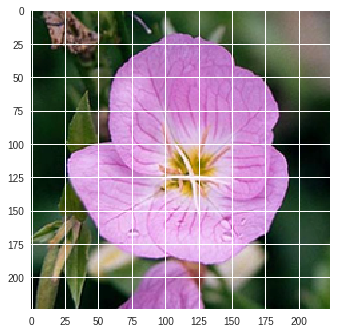

In [18]:
img = Image.open("/content/drive/My Drive/Colab Notebooks/flower_data/train/1/image_06734.jpg")
pi = process_image(img)
imshow(pi, None, None)

## Class Prediction

This shows that I can get images in the correct format. So now I write a function for making predictions with the model. A common practice is to predict the top 5 or so, most probable classes. I calculate the class probabilities  and then find the 5 largest values.

To get the top $k$ largest values in a tensor I  use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. I convert from these indices to the actual class labels using `class_to_idx` which I have added to the model or from an `ImageFolder` that I have used to load the data. I make sure to invert the dictionary so I get a mapping from index to class as well.

With this method  I should take a path to an image and a model checkpoint and then return the probabilities and classes. 
```

In [0]:
def predict(image_path, model): 
    img = Image.open(image_path)
    image = process_image(img)
    image = image.cuda()
    image.unsqueeze_(0)
    ps = torch.exp(model.forward(image.float()))
    probs, labls = ps.topk(5, dim=1) 
    probs = probs.detach().cpu().numpy().tolist()[0] 
    labls = labls.detach().cpu().numpy().tolist()[0]
    labels = [label_map[classes[lab]] for lab in labls]
    return  probs, labels 

## Sanity Checking


I should  make sure that the prediction that the model made, makes sense. Even if the validation accuracy is high, it's always good to check that there  isn't any obvious bug. I use `matplotlib` and `seaborn` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.  

I convert from the class integer encoding to the actual flower names with the `cat_to_name.json` file which already loaded earlier. I show a PyTorch tensor as an image. I use the `imshow` function I have defined before.

In [0]:
import seaborn as sns
def plot_solution(image_path, model):
    # set the plot
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)

    # set the title
    flower_class = image_path.split('/')[7]
    fl_ = label_map[flower_class]

    # plot the flower image
    pil_img = Image.open(image_path) 
    img = process_image(pil_img)
    imshow(img, ax, title = fl_);

    # predict 
    probs, labs = predict(image_path, model) 

    # plot the bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=labs, color=sns.color_palette()[0]);
    plt.show()

Now let us see how the model predict on the image: image_06743.jpg. In the following we can see that the model is not so certain about its prediction.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


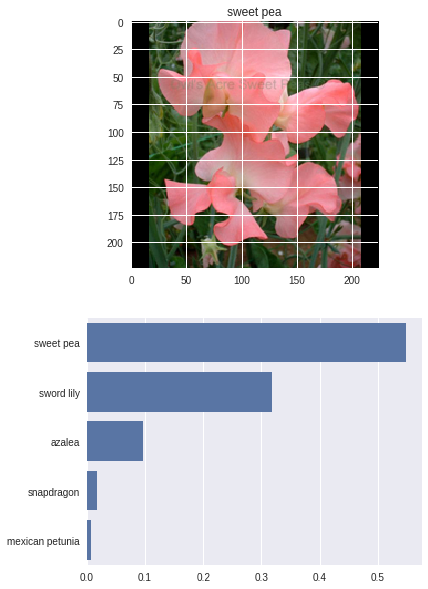

In [30]:
image_path = '/content/drive/My Drive/Colab Notebooks/flower_data/test/4/image_05636.jpg'
plot_solution(image_path, model)

However for some other image, as in the following, the model has no doubt and very certain about its prediction.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


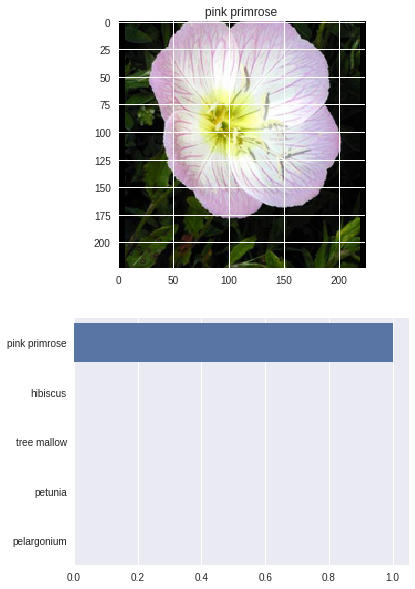

In [22]:
image_path = '/content/drive/My Drive/Colab Notebooks/flower_data/test/1/image_06743.jpg'
plot_solution(image_path, model)